---

# Proyecto 1: Hack a Boss
## Análisis del Top 10 ETFs

Proyecto de análisis del Top 10 de ETFs.

### Documentación del Proyecto

1. [Presentación Paula](https://docs.google.com/presentation/d/1Wk4tVhK89EP7b4iiIhvcTk4n5uHJkxgnuADb6Dk_Nto/edit?usp=sharing)

---





# Importación de **librerías**
### Incluid aquí las librerías a instalar e importar

In [ ]:
# Instalar las librerías
%pip install matplotlib
%pip install seaborn
%pip install yfinance
%pip install yahooquery
%pip install airtable-python-wrapper

In [42]:
# Importar las librerías
import time
import requests
import warnings
import numpy as np
import yfinance as yf
import yahooquery as yq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from pprint import pprint
import airtable
from tqdm import tqdm
warnings.filterwarnings("ignore")

# Sección Extracción de datos (API y WebScraping)





In [1]:
HEADERS = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

def seleccion_etf(tipo_etfs:str, num:int) -> list:
    # Obtención de los símbolos del Top ETFs de EEUU
    s = yq.Screener()
    dict_query = s.get_screeners(tipo_etfs, num)
    tickers = [symbol['symbol'] for symbol in dict_query[tipo_etfs]['quotes']]
    return tickers

def corregir_nombres_columnas(df_columns:pd.Index) -> pd.Index:
    # Eliminar caracteres especiales
    df_columns = df_columns.str.replace('[^\w\s]', '', regex=True)
    # Sustituir espacios por _
    df_columns = df_columns.str.replace(' ', '_')
    # Retornar el DF
    return(df_columns)

def convertir_a_largo(df):
    # Resetear índice
    df_reset = df.reset_index()
    # Convertir el dataframe a formato largo
    df_melted = df_reset.melt(id_vars='Date', var_name=['Attribute', 'Ticker'], value_name='Value')
    # Una columna para cada cosa
    df_melted['Attribute'] = df_melted['Attribute'].astype(str)
    df_pivoted = df_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='Value').reset_index()
    # Ponerlo todo bien y en orden
    df_pivoted.columns.name = None
    df_pivoted = df_pivoted[['Date', 'Ticker', 'Adj Close', 'Volume']]
    df_pivoted = df_pivoted.rename(
        columns={
            'Date':'Fecha',
            'Ticker':'Ticker',
            'Adj Close':'Precio',
            'Volume':'Volumen'
            }
        )
    # Retornar dataframe
    return df_pivoted

def convertir_a_ancho(df_indexado):
    # Convertir el DataFrame a formato largo
    df_wide = df_indexado.pivot_table(index='Fecha', columns=['Attribute', 'Ticker'], values='Precio')
    # Retornar el DataFrame en formato ancho
    return df_wide

def down_price_vol(tickers:list) -> pd.DataFrame:
    # Descarga de las cotizaciones
    df = yf.download(tickers, period='max')
    # Obtener los nombres de las columnas para 'Adj Close' y 'Volume'
    adj_close_cols = [('Adj Close', ticker) for ticker in tickers]
    volume_cols = [('Volume', ticker) for ticker in tickers]

    # Seleccionar las columnas de interés
    df = df[adj_close_cols + volume_cols]
    # Eliminar valores nulos y cambiar los precios por incrementos porcentuales
    df = df.dropna().pct_change(1).dropna()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    # Retornar DataFrame
    return(df)

def web_scraping_sectors(tickers:list) -> pd.DataFrame:
    url_base = "https://es.finance.yahoo.com/quote/"
    lista_sectores = [
        "Materiales básicos", "Acciones cíclicas", "Servicios financieros",
        "Propiedades inmobiliarias", "Acciones defensivas", "Atención sanitaria",
        "Utilidades", "Servicios de comunicación", "Energía", "Industriales",
        "Tecnología"
    ]
    dict_sectores = {}
    for etf in tqdm(tickers):
        url = f'{url_base}{etf}/holdings?p={etf}'
        response = requests.get(
            url,
            headers = HEADERS
            )
        soup = BeautifulSoup(response.text, 'html.parser')
        sectores_etf = {}
        lista_contenedores = soup.findAll('div', class_='Bdbw(1px) Bdbc($seperatorColor) Bdbs(s) H(25px) Pt(10px)')
        for item in lista_contenedores:
            sector = item.find('span', class_='Mend(5px) Whs(nw)').text
            if sector in lista_sectores:
                valor = item.find('span', class_='W(20%) D(b) Fl(start) Ta(e)').text
                sectores_etf[sector] = valor
        dict_sectores[etf] = sectores_etf
    # Convertir diccionario en dataframe
    df = pd.DataFrame.from_dict(dict_sectores).T
    # Convertir todas las entradas a strings, eliminar el '%' y reemplazar comas por puntos
    df = df.map(lambda x: str(x).replace('%', '').replace(',', '.'))
    # Convertir las cadenas a números flotantes y dividir por 100 para tener los porcentajes en formato decimal
    df = df.map(lambda x: float(x) / 100.0 if x != 'N/A' else 0)
    # Quitar los espacios
    df.columns = corregir_nombres_columnas(df.columns)
    # Resetear índice
    df = df.reset_index()
    df = df.rename(columns={'index':'Ticker'})
    # Retornar DataFrame
    return (df)

def tabla_net_assets(tickers:list) -> pd.DataFrame:
    def convertir_valor(valor):
        if 'M' in valor:
            return float(valor.replace('M', ''))
        elif 'B' in valor:
            return float(valor.replace('B', '')) * 1000
        else:
            return float(valor)
    #Net assets table
    net_assets = pd.DataFrame()
    for ticker in tqdm(tickers):
        url = f"https://finance.yahoo.com/quote/{ticker}?p={ticker}"
        response = requests.get(url, headers=HEADERS)
        try:
            tables = pd.read_html(response.text)
            for table in tables:
                labels_to_remove = ["Previous Close", "Open", "Bid", "Ask", "Day's Range", "52 Week Range", "Volume","Avg. Volume"]
                table = table[~table.iloc[:, 0].isin(labels_to_remove)]
                data_series = pd.Series(dict(zip(table.iloc[:, 0], table.iloc[:, 1])))
                net_assets[ticker] = data_series
        except ValueError:
            print(f"No hay tablas para {ticker}")
    net_assets = net_assets.T
    # Eliminar columnas
    df = net_assets.drop(['NAV', 'PE Ratio (TTM)', 'Expense Ratio (net)'], axis=1)
    # Corregir nombres de columnas
    df.columns = corregir_nombres_columnas(df.columns)
    # Convertir todas las entradas a strings, eliminar el '%' y reemplazar comas por puntos
    df[['Yield', 'YTD_Daily_Total_Return']] = df[['Yield', 'YTD_Daily_Total_Return']].map(lambda x: str(x).replace('%', ''))
    # Convertir las cadenas a números flotantes y dividir por 100 para tener los porcentajes en formato decimal
    df[['Yield', 'YTD_Daily_Total_Return']] = df[['Yield', 'YTD_Daily_Total_Return']].map(lambda x: float(x) / 100.0)
    # Convertir la columna Beta a float
    df['Beta_5Y_Monthly'] = df['Beta_5Y_Monthly'].astype(float)
    # Convertir Inception_Date en datetime
    df['Inception_Date'] = pd.to_datetime(df['Inception_Date'], format='%Y-%m-%d')
    # Reformatear columna Net_Assets
    df['Net_Assets_Millions'] = df['Net_Assets'].apply(convertir_valor)
    df = df.drop('Net_Assets', axis=1)
    # Resetear índice
    df = df.reset_index()
    df = df.rename(columns={'index':'Ticker'})
    # Retornar df
    return(df)

def portafolio_activos_etfs(tickers:list)->pd.DataFrame:
    all_dataframes = []
    for ticker in tqdm(tickers):
        url = f"https://finance.yahoo.com/quote/{ticker}/holdings?p={ticker}"
        response = requests.get(url, headers=HEADERS)
        try:
            tables = pd.read_html(response.text)
            for table in tables:
                table['Ticker'] = ticker  # Add the 'Ticker' column
                all_dataframes.append(table)
        except ValueError:
            print(f"No tables found for {ticker}")
    # Concatenate all dataframes
    df = pd.concat(all_dataframes, ignore_index=True)
    # Corregir nombres de columnas
    df.columns = corregir_nombres_columnas(df.columns)
    df.rename(columns={"_Assets":"Assets"}, inplace=True)
    # Convertir todas las entradas a strings, eliminar el '%' y reemplazar comas por puntos
    df['Assets'] = df['Assets'].map(lambda x: str(x).replace('%', ''))
    # Convertir las cadenas a números flotantes y dividir por 100 para tener los porcentajes en formato decimal
    df['Assets'] = df['Assets'].map(lambda x: float(x) / 100.0)
    # Retornar df
    return(df)

NameError: name 'pd' is not defined

In [44]:
# Esta línea se ha de ejecutar una sola vez
# en todo el proyecto, si se hace, es posible que
# el Top de ETFs cambie y no se correspondan con los
# almacenados en Airtable
#tickers = seleccion_etf('top_etfs_us', 25)

In [45]:
#df_price_vol = convertir_a_indexado(down_price_vol(tickers))
#df_sect_dist = web_scraping_sectors(tickers)
#df_net_activos = tabla_net_assets(tickers)
#df_portafolio_activos = portafolio_activos_etfs(tickers)

[*********************100%%**********************]  25 of 25 completed


100%|██████████| 25/25 [00:25<00:00,  1.04s/it]


# Carga de datos a Airtable

In [46]:
'''
# Parámetros de airtable y creación del objeto airtable
base_id = 'app8fsCvHI7Tau4le'
api_key = 'patyBg6zyoW4EXNI7.205cca8c88a716fa4010850bd58995623d060734e24fa937be40f428d3bfb7fe'
# Definir tabla id con dataframe
lista_dataframes = [
    ('tblkKLqcgl5dDo6uI', df_price_vol),
    ('tblWV2ERYBOrXozth', df_sect_dist),
    ('tblvbY1n5rzmFyBqZ', df_net_activos),
    ('tblvxs74FGznyUCfL', df_portafolio_activos)
    ]'''

In [47]:
'''
# Bucle para subir los datos a Airtabl
for tabla_id, dataframe in lista_dataframes:
    air = airtable.Airtable(base_id=base_id, table_name=tabla_id, api_key=api_key)
    # Convertir las columnas datetime a stings
    for col in dataframe.columns:
        if pd.api.types.is_datetime64_any_dtype(dataframe[col]):
            dataframe[col] = dataframe[col].dt.strftime('%Y-%m-%d')
    # Subir en lotes de 10
    for i in range(0, len(dataframe), 10):
        bloque = dataframe.iloc[i:i+10]
        registros = bloque.to_dict(orient="records")
        air.batch_insert(registros)
'''

# Sección Funciones Estadísticas

### Descarga de datos de Airtable

In [23]:
# Dataframe sectores
air = airtable.Airtable(base_id=base_id, table_name='tblWV2ERYBOrXozth', api_key=api_key)
lista_de_diccionarios = air.get_all()
lista_de_fields = [d['fields'] for d in lista_de_diccionarios]
df_divsf_sect = pd.DataFrame(lista_de_fields)
# Dataframe de activos netos
air = airtable.Airtable(base_id=base_id, table_name='tblvbY1n5rzmFyBqZ', api_key=api_key)
lista_de_diccionarios = air.get_all()
lista_de_fields = [d['fields'] for d in lista_de_diccionarios]
df_divsf_activos = pd.DataFrame(lista_de_fields)
# Seleccionamos 
df_divsf_activos_reduced = df_divsf_activos[['Ticker', 'Yield', 'Beta_5Y_Monthly']]
# Realizamos un merge
df_divsf_rend = pd.merge(df_divsf_sect, df_divsf_activos_reduced, on='Ticker', how='right')
df_divsf_rend = df_divsf_rend.rename(columns={'Yield':'Rentabilidad', 'Beta_5Y_Monthly':'Riesgo'})

### Identificar el sector con la mayor inversión en promedio

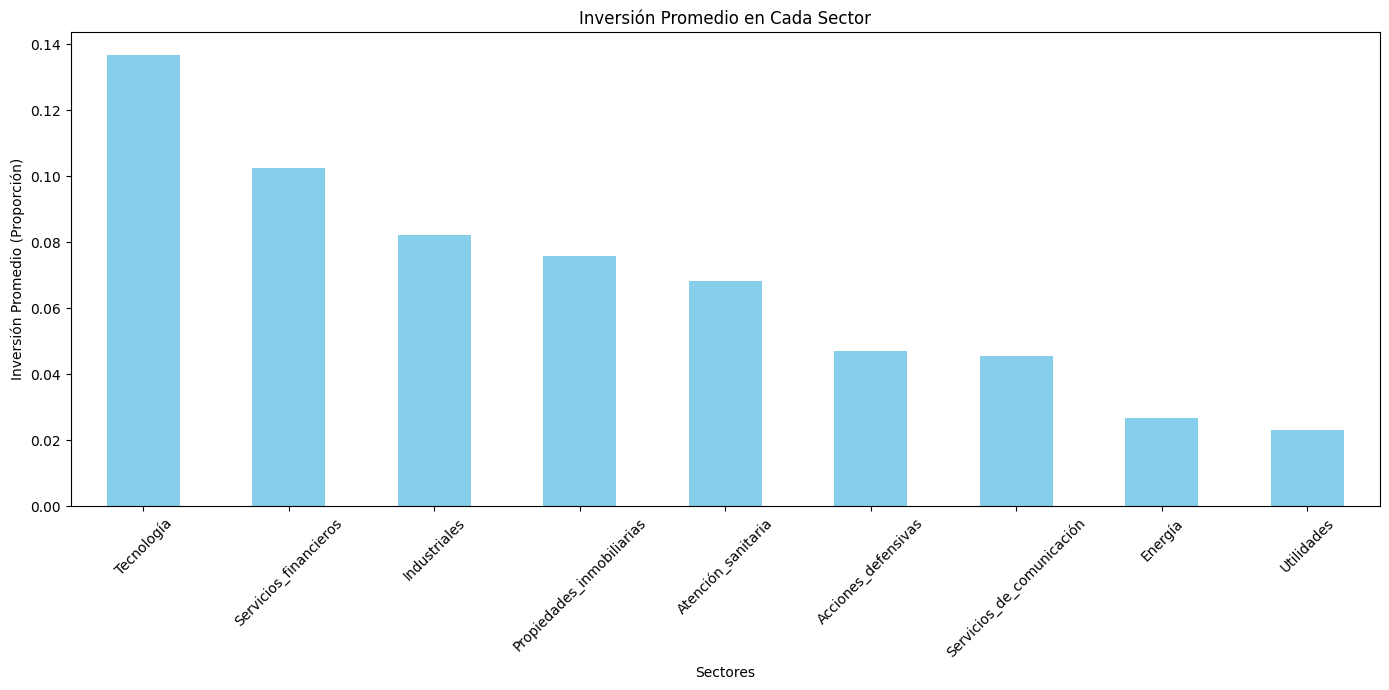

In [84]:
# Cálculo y selección
sector_columns = df_divsf_rend.columns[2:-3]
df_grafico_1 = df_divsf_rend[sector_columns].mean().sort_values(ascending=False)
# Visualización
plt.figure(figsize=(14,7))
df_grafico_1.plot(kind='bar', color='skyblue')
plt.title('Inversión Promedio en Cada Sector')
plt.xlabel('Sectores')
plt.ylabel('Inversión Promedio (Proporción)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Determinar el umbral para los ETFs más rentables (el cuartil superior)

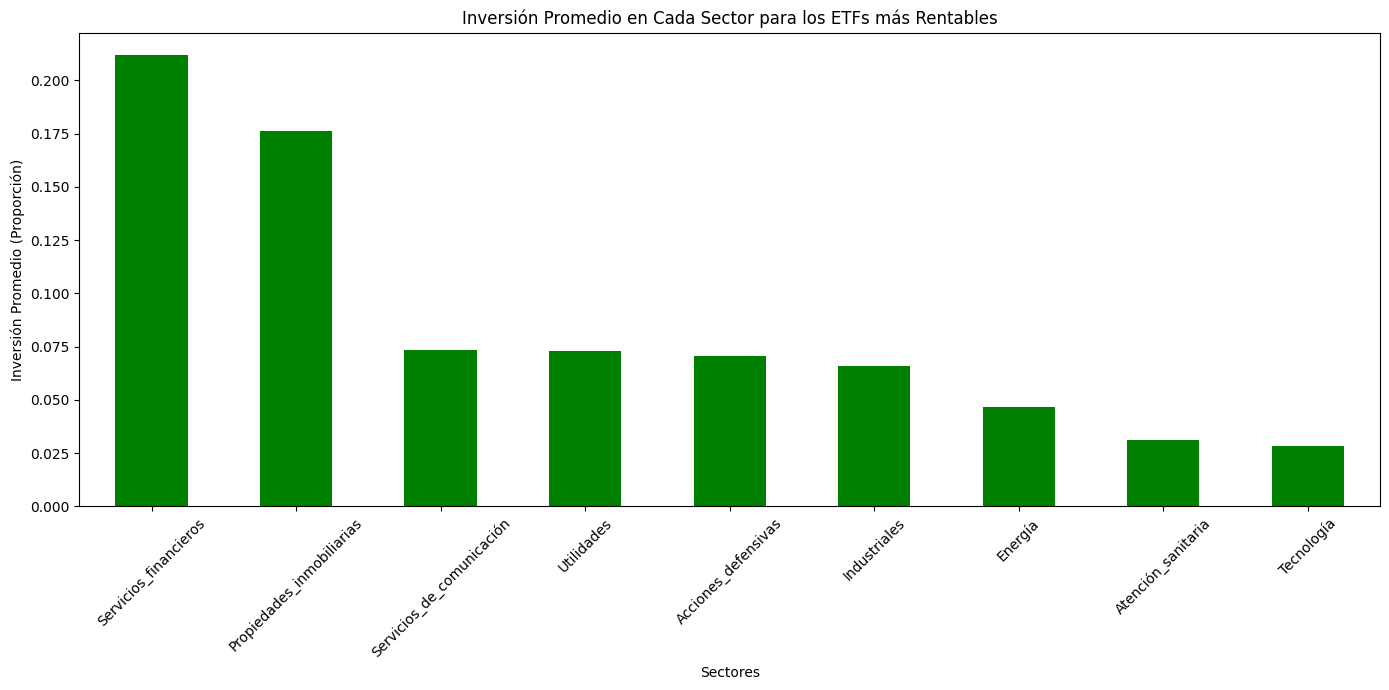

In [85]:
quantil_rentabilidad = df_divsf_rend['Rentabilidad'].quantile(0.75)
etfs_mas_rentables = df_divsf_rend[df_divsf_rend['Rentabilidad'] >= quantil_rentabilidad]
# Calcular
df_grafico_2 = etfs_mas_rentables[sector_columns].mean().sort_values(ascending=False)
# Visualizar
plt.figure(figsize=(14,7))
df_grafico_2.plot(kind='bar', color='green')
plt.title('Inversión Promedio en Cada Sector para los ETFs más Rentables')
plt.xlabel('Sectores')
plt.ylabel('Inversión Promedio (Proporción)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Top rentabilidad-riesgo ETFs

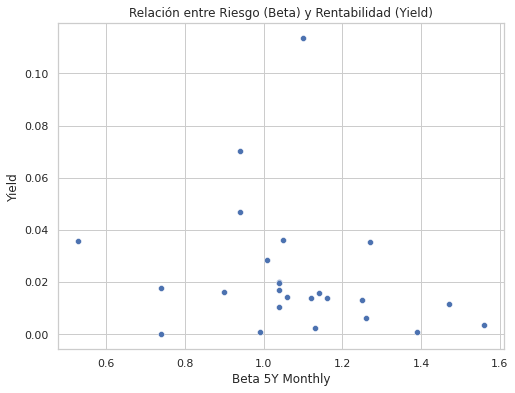

In [25]:
# Crear un gráfico de dispersión para la relación entre Beta_5Y_Monthly y Yield
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.scatterplot(data=df_divsf_activos, x="Beta_5Y_Monthly", y="Yield")
plt.title("Relación entre Riesgo (Beta) y Rentabilidad (Yield)")
plt.xlabel("Beta 5Y Monthly")
plt.ylabel("Yield")
plt.show()

### Activos que más se repiten

In [2]:
air = airtable.Airtable(base_id=base_id, table_name='tblvxs74FGznyUCfL', api_key=api_key)
lista_de_diccionarios = air.get_all()
lista_de_fields = [d['fields'] for d in lista_de_diccionarios]
df_activos_repiten = pd.DataFrame(lista_de_fields)

NameError: name 'base_id' is not defined

In [ ]:
symbol_etf_count = df_activos_repiten.groupby('Symbol')['Ticker'].nunique()
symbol_etf_count_df = symbol_etf_count.reset_index()
symbol_etf_count_df.columns = ['Symbol', 'ETF_Count']
symbol_etf_count_df = symbol_etf_count_df.sort_values(by='ETF_Count', ascending=False)
symbol_etf_count_filtered_df = symbol_etf_count_df[symbol_etf_count_df['ETF_Count'] >= 2]
symbol_etf_count_filtered_df = symbol_etf_count_filtered_df.reset_index(drop=True)
# Agregar la ponderación según los activos netos
air = airtable.Airtable(base_id=base_id, table_name='tblvbY1n5rzmFyBqZ', api_key=api_key)
lista_de_diccionarios = air.get_all()
lista_de_fields = [d['fields'] for d in lista_de_diccionarios]
df_activos_netos = pd.DataFrame(lista_de_fields)
# Que no por el hecho de que se repita significa que están
# aportando mayor rentabilidad a los ETFs que invierten en él.

### Análisis serie temporal

In [38]:
base_id = 'app8fsCvHI7Tau4le'
api_key = 'patyBg6zyoW4EXNI7.205cca8c88a716fa4010850bd58995623d060734e24fa937be40f428d3bfb7fe'
air = airtable.Airtable(base_id=base_id, table_name='tblkKLqcgl5dDo6uI', api_key=api_key)
lista_de_diccionarios = air.get_all()
lista_de_fields = [d['fields'] for d in lista_de_diccionarios]
df_price_vol = pd.DataFrame(lista_de_fields)

In [41]:
df_price_vol.head()

,Fecha,Ticker,Precio,Volumen
0,2019-02-28,CHIQ,0.003119,4.844444
1,2020-10-20,IDX,0.005949,-0.870253
2,2020-01-14,NURE,-0.003852,7.911765
3,2019-07-03,GOAU,0.008517,-0.796117
4,2020-02-28,KARS,-0.013781,-0.227053


In [40]:
df_price_vol_temp = convertir_a_ancho(df_price_vol)
df_price_vol_temp.head()

KeyError: 'Attribute'

In [ ]:
df_price_vol_temp.columns

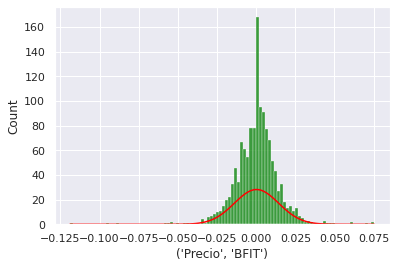

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Sumamos todas las variaciones porcentuales para obtener la variación total
total_pct_change = df_price_vol_temp['Precio'].sum(axis=1)
# Ahora, dibujamos el histograma de la suma de todas las variaciones porcentuales
sns.histplot(total_pct_change, bins=100, kde=False, color="green")
# Ajustamos una distribución normal a la suma de todas las variaciones porcentuales
params = stats.norm.fit(total_pct_change)
x = np.linspace(total_pct_change.min(), total_pct_change.max(), 100)
y = stats.norm.pdf(x, *params)
plt.plot(x, y, color="red")  # Dibuja la distribución ajustada
plt.show()

### Relación Activos Netos vs Rentabilidad vs Riesgo

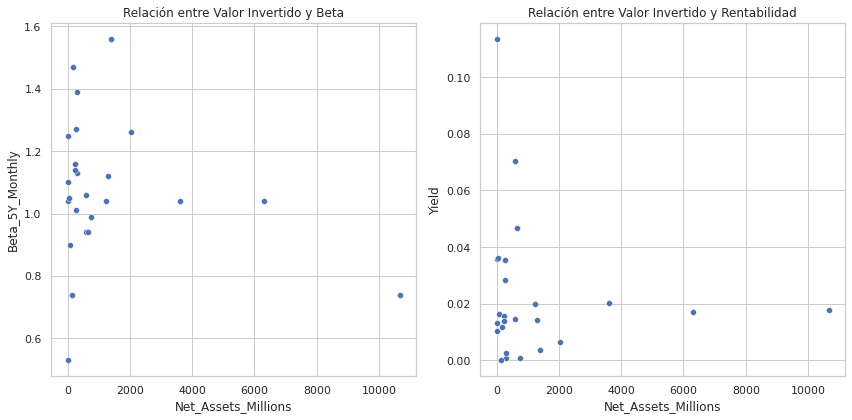

In [24]:

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Gráfico de dispersión entre Beta_5Y_Monthly y Net_Assets_Millions
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_divsf_activos, x="Net_Assets_Millions", y="Beta_5Y_Monthly")
plt.title("Relación entre Valor Invertido y Beta")

# Gráfico de dispersión entre Yield y Net_Assets_Millions
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_divsf_activos, x="Net_Assets_Millions", y="Yield")
plt.title("Relación entre Valor Invertido y Rentabilidad")

plt.tight_layout()
plt.show()

In [ ]:
# Calculamos la tasa de crecimiento anual compuesto y el resultado de comprar y mantener

Años = df_price_vol["R. Aritmetico"].count() / 252
CAGR = (df_price_vol["Adj Close"].iloc[-1]/ df_price_vol["Adj Close"].iloc[0]) ** (1 / Años) -1
print(50*"=")
print("> Tasa de Crecimiento Anual Compuesto:","%.6s" % (100 * CARG) , "%")
print("> Buy & Hold:", "%6s" % (100*((df_price_vol["Adj Close"].iloc[-1] -
       df_price_vol["Adj Close"].iloc[0])/df_price_vol["Adj Close"].iloc[0])),"%")

# Calculamos el Maximo Drawdown.
Maximo_Anterior = df_price_vol["Adj Close"].cummax()
drawdowns = 100*((df_price_vol["Adj Close"] - Maximo_Anterior)/Maximo_Anterior )
DD = pd.DataFrame({"Adj Close": df_price_vol["Adj Close"],
                   "Previous Peak": Maximo_Anterior ,
                   "Drawdown": drawdowns})

print("> Maximo Drawdown Historico:", "%.6s" % np.min(DD["Drawdown"]), "%")

# Obtenemos el  Promedio, desviación tipica, máximo y mínimo valor y número de datos analizados:

print("> Media Diaria:","%.6s" % (100 * df_price_vol["R. Aritmetico"].mean()), "%")
print("> Desviación Tipica Diaria:","%.6s" % (100 * df_price_vol["R. Aritmetico"].std.(ddof=1)),"%")
print("> Másxima Pérdida Diaria:","%.6s" % (100* df_price_vol["R. Aritmetico"].min()),"%")
print("> Máximo Beneficio Diario:","%.6s" % (100 * df_price_vol["R. Aritmetico"].max()),"%")
print("> Días Analizados:", "%.6s" % df_price_vol["R. Aritmetico"].count())
print(50*"=")

# Coeficiente de Asimetria y curtosis de la distribución.
print("> Coeficiente de Asimetria:", "%.6s" % df_price_vol["R. Aritmetico"].skew())
print("> Curtosis:", "%.6s" % df_price_vol["R. Aritmetico"].kurt())
print(50*"=")

# VaR Teórico obtenido a través de la distribución normal al 95% y 99% de confianza
print("> VaR Modelo Gaussiano NC-95%:", "%.6s" % (100 * norm.ppf(0.05, mu, sigma)), "%")
print("> VaR Modelo Gaussiano NC-99%:", "%.6s" % (100 * norm.ppf(0.01, mu, sigma)), "%")
print("> VaR Modelo Gaussiano NC-99.7%:", "%.6s" % (100 * norm.ppf(0.003, mu, sigma)), "%")

# VaR histórico al 95% y 99% de confianza.
print("> VaR Modelo Historico NC-95%:", "%.6s" % (100 * np.percentile(df_price_vol["R. Aritmetico"],5)), "%")
print("> VaR Modelo Historico NC-99%:", "%.6s" % (100 * np.percentile(df_price_vol["R. Aritmetico"],1)), "%")
print("> VaR Modelo Historico NC-99.7%:", "%.6s" % (100 * np.percentile(df_price_vol["R. Aritmetico"],.3)), "%")
print(50*"=")


In [ ]:
# Calculamos La volatilidad histérica de 14 dias, La volatilidad anualizada y su SMA de 252 dias.
df_price_vol["Volatilidad Historica 14 Dias"] = 100*df_price_vol["R. Aritmetico"].rolling(14).std()
df_price_vol["Volatilidad 14 Dias Anualizada"] = df_price_vol["Volatilidad Historica_14 Dias"]*(252**0.5)
df_price_vol["SMA_126 Volatilidad_Anualizada"] = df_price_vol["Volatilidad_14 Dias Anualizada"].rolling(126).mean()
#1 Creamos una figura y creamos un nuevo eje X e ¥

fig, ax1 = plt.subplots(figsize=(15, 8))

#2 Creamos un nuevo eje. Aqui el eje X es invisible y el eje Y se situa en el Lado opuesto del original.
ax2 = ax1.twinx()

# Creamos Los objetos que queremos dibujar en Los ejes axl y ax2

volatilityLine = ax1.plot(df_price_vol["Volatilidad_14 Dias _Anualizada"], "orange", linestyle="--", label = "Vol. 14 días Anualizada")
smaLine = ax1.plot(df_price_vol["SMA_126 Volatilidad_Anualizada"], "green", linestyle="-", label = "SMA 126 Vol. Anualizada")
adjustedCloseLine = ax2.plot(df_price_vol["Adj Close"], "black", label = "Precio de Cierre Ajustado")

# Titulo del grafico.
plt.title("Evolución histórica del precio y la volatilidad", fontsize=16)

# Etiquetas de los ejes x e y.

ax1.set_xlabel ("Fecha")
ax1.set_ylabel("Volatilidad Anualizada", color="black")
ax2.set_ylabel("Precio de Cierre", color="black")

# Creamos una Lista con Los diferentes Plots que tengamos (Aqui tres)
plotLines = volatilityLine + smaLine + adjustedCloseLine

# Creamos una nueva Lista extrayendo Las etiquetas de cada plot.

labels = [line.get_label() for line in plotLines]

# En La Leyenda incluimos La Lista de Plots y Las etiquetas de cada plot.
ax1.legend(plotlines, labels, loc="upper left", frameon=True, borderpad=1)

ax1.grid(True)
ax2.grid(False)

plt.show()

In [ ]:
# Volatilidad anualizada.
VAM = (252**0.5)*(100 * df_price_vol["R. Aritmetico"].std())
print("> Volatilidad Anualizada:",'%.6s' % VAM ,"%")

# Obtenemos el valor minimo y maximo de La volatilidad anualizada asi como Las fechas
# en Las que ambos valores son producidos.

Fecha_Minima_Volatilidad = df_price_vol.Volatilidad_14_Dias_Anualizada[df_price_vol.Volatilidad_14 Dias_Anualizada ==
                           df_price_vol["Volatilidad_14_Dias_Anualizada"].min()].index.strftime("%Y-%m-%d").tolist()

Fecha_Maxima_Volatilidad = df_price_vol.Volatilidad_14_Dias_Anualizada[df_price_vol.Volatilidad_14 Dias_Anualizada ==
                           df_price_vol["Volatilidad_14_Dias_Anualizada"].max()].index.strftime("%Y-%m-%d").tolist()

print("> La Minima Volatilidad Anualizada fue de", '%.6s' %
       (df_price_vol["Volatilidad_14_Dias_Anualizada"].min()),
       "%", "registrada el", Fecha_Minima_Volatilidad[0] )

print("> La Máxima Volatilidad Anualizada fue de", '%.6s' %
       (df_price_vol["Volatilidad_14_Dias_Anualizada"].max()),
       "%", "registrada el", Fecha_Minima_Volatilidad[0] )


# Obtenemos el promedio sobre el rango porcentual de Los dias negativos.

df_price_vol["DiasNegativos"] = np.where(df_price_vol["R. Aritmetico"] > 0, 100*(df_price_vol["High"]-df_price_vol["Low"])/df_price_vol["Low"],0)
df_dias_negativos = df_price_vol.loc[df_price_vol["DiasNegativos"] != 0]
DN = df_dias_negativos[ "DiasNegativos"].mean()
print("> Rango Medio dias Negativos:",'%.4s' % DN ,"%")

# Obtenemos el promedio del rango porcentgual de Los dias positivos.

df_price_vol["DiasPositivos"] = np.where(df_price_vol["R. Aritmetico"] > 0, 100*(df_price_vol["High"]-df_price_vol["Low"])/df_price_vol["Low"],0)
df_dias_positivos = df_price_vol.loc[df_price_vol["DiasPositivos"] != 0]
DP = df_dias_positivos[ "DiasPositivos"].mean()
print("> Rango Medio dias Positivos:",'%.4s' % DP ,"%")

# Calulamos el ratio del rango entre dias positivos y negativos.
print("> Ratio RDN/RDP",'%.4s'%(DN/DP), "%") 

In [ ]:
# Importamos adfuller de la librería statsmodels
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Realizamos la prueba sobre la columna Adj Close de nuestro DataFrame y obtenemos el T-Test
adf = adfuller(df_price_vol["Adj Close"], maxlag = 1)
print(("El T-Test es:", adf[0]))

In [ ]:
print("El P-Value es:", adf[1])
print("Valores críticos:", adf[4])

In [ ]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract

def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 20)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

print ("> Hurst Exponent:", "%.6s" % hurst(df_price_vol["Close"]))

In [ ]:
# Importamos mean de La Libreria statistics
from statistics import mean

# Creamos una nueva Lista Llamada MyHValues en La que almacenaremos Los valores
# registrados por el Exponente de Hurst.
MyHValues =[]

# Definimos el tamafño de cada bloque de datos y creamos Las variables necesarias
# para dividir La serie en bloques a través del bucle while.

Bloque_Datos = 253

Start = 0

End = Bloque_Datos

# EL siguiente bucle nos permite dividir la serie temporal en bloques de 252 datos,
# aplicar en cada bloque la función del Exponente de Hurst, e incluir en la Lista
# MyHvaLues cada uno de los valores registrados.

while Start < df.shape[0]:

    df_price_vol["H1"] = df_price_vol["Close"][Start :End]
    MyHValues. append(hurst(df_price_vol["H1"]))
    Start += Bloque_Datos
    End += Bloque_Datos

# Mostramos La media de todos Las observaciones.
print("Media del Exponente de Hurst (H): {:.2f}".format(mean(MyHValues)))

# Creamos un gráfico en el que mostramos La evolución histórica del Expontente de Hurst.
plt.figure(figsize=(15, 8))
plt.plot(MyHValues, label = "Exponente de Hurst (H)")
plt.plot(MyHValues, "ro")
plt.axhline(y = mean(MyHValues), color = "red", linestyle = "dashed",
            label = "Media del Exponente de Hurst (H)")
plt.axhline(y = 0.5, color='black', linestyle='--',label = "Movimiento Geométrico Browniano")
plt.title("Exponente de Hurst (H) (253 Periodos)",fontsize = 16)
plt.ylabel ("Exponente de Hurst (H)", fontsize = 14)
plt.xlabel ("Observaciones",fontsize = 14)
plt.legend(loc = "upper left", frameon = True, borderpad = 1)
plt.show()
